In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# for showing all the plots inline
%matplotlib inline

#https://www.kaggle.com/amar09/sentiment-analysis-on-scrapped-tweets

In [2]:
class SeleniumClient(object):
    def __init__(self):
        #Initialization method. 
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--disable-setuid-sandbox')

        # you need to provide the path of chromdriver in your system
        self.browser = webdriver.Chrome('D:/chromedriver_win32/chromedriver', options=self.chrome_options)

        self.base_url = 'https://twitter.com/search?q='

    def get_tweets(self, query):
        #Function to fetch tweets. 
        try: 
            self.browser.get(self.base_url+query)
            time.sleep(2)

            body = self.browser.find_element_by_tag_name('body')

            for _ in range(3000):
                body.send_keys(Keys.PAGE_DOWN)
                time.sleep(0.3)

            timeline = self.browser.find_element_by_id('timeline')
            tweet_nodes = timeline.find_elements_by_css_selector('.tweet-text')

            return pd.DataFrame({'tweets': [tweet_node.text for tweet_node in tweet_nodes]})

        except:
            print("Selenium - An error occured while fetching tweets.")

In [3]:
consumer_key = "vpnPkJCbbap6iX5ziCMELLvBV"
consumer_secret = "CyN4iLOf0G251V24egT0uRspV57CU3XyTM5jn3MGZuTcrGl0ug"
access_token = "3384249591-3op63SrINIvkf59K2cnbcGznzOf8hEnPWH55mZd"
access_token_secret = "JFLSHOndfkY4pBi3R81f26VsRQurh7TtXEqUK5Acpc4l8"

In [4]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [6]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets("#hairdye OR #haircolor OR #hairstyle", maxTweets=7000)

print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 95 tweets
Downloaded 190 tweets
Downloaded 275 tweets
Downloaded 375 tweets
Downloaded 475 tweets
Downloaded 570 tweets
Downloaded 647 tweets
Downloaded 740 tweets
Downloaded 823 tweets
Downloaded 893 tweets
Downloaded 980 tweets
Downloaded 1075 tweets
Downloaded 1170 tweets
Downloaded 1262 tweets
Downloaded 1352 tweets
Downloaded 1433 tweets
Downloaded 1507 tweets
Downloaded 1597 tweets
Downloaded 1683 tweets
Downloaded 1752 tweets
Downloaded 1839 tweets
Downloaded 1936 tweets
Downloaded 2031 tweets
Downloaded 2118 tweets
Downloaded 2201 tweets
Downloaded 2288 tweets
Downloaded 2367 tweets
Downloaded 2448 tweets
Downloaded 2534 tweets
Downloaded 2625 tweets
Downloaded 2719 tweets
Downloaded 2802 tweets
Downloaded 2889 tweets
Downloaded 2981 tweets
Downloaded 3067 tweets
Downloaded 3157 tweets
Downloaded 3257 tweets
Downloaded 3348 tweets
Downloaded 3446 tweets
Downloaded 3545 tweets
Downloaded 3634 tweets
Downloaded 3731 tweets
Downloaded 3819 tweets
Downloaded 3916 tweets


,tweets
0,coloured flower earrings https://t.co/qm238uCZ...
1,RT @DreamIrishWedd: #weddingwednesday A textur...
2,今日の寝癖です\n2019.3.21\n#寝癖 #寝癖コレクション #ボブ #寝癖アート #...
3,RT @elifkes80: @kurretulayn 🔥\nHem kalbi hem k...
4,Christmas tree slide charm https://t.co/yU0Il4...
5,Beautiful model for this pretty flower headban...
6,// v i o l e t \\\n.\n.\n.\n#hairstyle #hairco...
7,@kurretulayn 🔥\nHem kalbi hem kendi güzel 😍\nM...
8,ulianka.stets ♥️\n\n#Drohobych #Ukraine #portr...
9,LOOKING FOR THE BEST HAIR CARE PRODUCTS? WE HA...


In [7]:
# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,5915
neg,349


In [8]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

,tweets,sentiment
0,coloured flower earrings https://t.co/qm238uCZ...,pos
1,RT @DreamIrishWedd: #weddingwednesday A textur...,pos
2,今日の寝癖です\n2019.3.21\n#寝癖 #寝癖コレクション #ボブ #寝癖アート #...,pos
3,RT @elifkes80: @kurretulayn 🔥\nHem kalbi hem k...,pos
4,Christmas tree slide charm https://t.co/yU0Il4...,pos


In [9]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [10]:
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")

In [11]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets

In [12]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']

In [13]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)

,tweets,sentiment,tidy_tweets
0,coloured flower earrings https://t.co/qm238uCZ...,pos,coloured flower earrings #gadgets #gifts #ebay...
1,RT @DreamIrishWedd: #weddingwednesday A textur...,pos,#weddingwednesday A textured updo with sweepin...
2,今日の寝癖です\n2019.3.21\n#寝癖 #寝癖コレクション #ボブ #寝癖アート #...,pos,今日の寝癖です 2019.3.21 #寝癖 #寝癖コレクション #ボブ #寝癖アート #寝癖...
3,RT @elifkes80: @kurretulayn 🔥\nHem kalbi hem k...,pos,@kurretulayn 🔥 Hem kalbi hem kendi güzel 😍 MAŞ...
4,Christmas tree slide charm https://t.co/yU0Il4...,pos,Christmas tree slide charm #gadgets #gifts #eb...
5,Beautiful model for this pretty flower headban...,pos,Beautiful model for this pretty flower headban...
6,// v i o l e t \\\n.\n.\n.\n#hairstyle #hairco...,pos,// v i o l e t \\ . . . #hairstyle #haircolor ...
7,@kurretulayn 🔥\nHem kalbi hem kendi güzel 😍\nM...,pos,@kurretulayn 🔥 Hem kalbi hem kendi güzel 😍 MAŞ...
8,ulianka.stets ♥️\n\n#Drohobych #Ukraine #portr...,pos,ulianka.stets ♥️ #Drohobych #Ukraine #portrait...
9,LOOKING FOR THE BEST HAIR CARE PRODUCTS? WE HA...,pos,LOOKING FO THE BEST HAI CAE PODUCTS? WE HAVE T...


In [14]:
tweets_df = tweets_df.reset_index(drop=True)

In [15]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

In [16]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet

0       [coloured, flower, earrings, #gadgets, #gifts,...
1       [#weddingwednesday, A, textured, updo, with, s...
2       [#, #, #, #, #, #, #, #, #, #, #, #neguse, #ha...
3       [kurretulayn, Hem, kalbi, hem, kendi, gzel, MA...
4       [Christmas, tree, slide, charm, #gadgets, #gif...
5       [Beautiful, model, for, this, pretty, flower, ...
6       [v, i, o, l, e, t, #hairstyle, #haircolor, tha...
7       [kurretulayn, Hem, kalbi, hem, kendi, gzel, MA...
8       [uliankastets, #Drohobych, #Ukraine, #portrait...
9       [LOOKING, FO, THE, BEST, HAI, CAE, PODUCTS, WE...
10      [Just, got, my, hair, did, and, Im, happy, #sp...
11      [kurretulayn, Senin, filtreye, ihtiyacn, yok, ...
12      [Straight, vs, Wavy, Sometimes, the, hair, say...
13      [We, give, you, permission, to, be, obsessed, ...
14      [#letter, #letterbynovel, #, #, #, #, #, #, #,...
15      [When, you, realize, you, created, your, cousi...
16      [Bald, receding, hairline, Stop, hair, loss, g...
17      [Do, y

In [17]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet

In [18]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

In [19]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [20]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

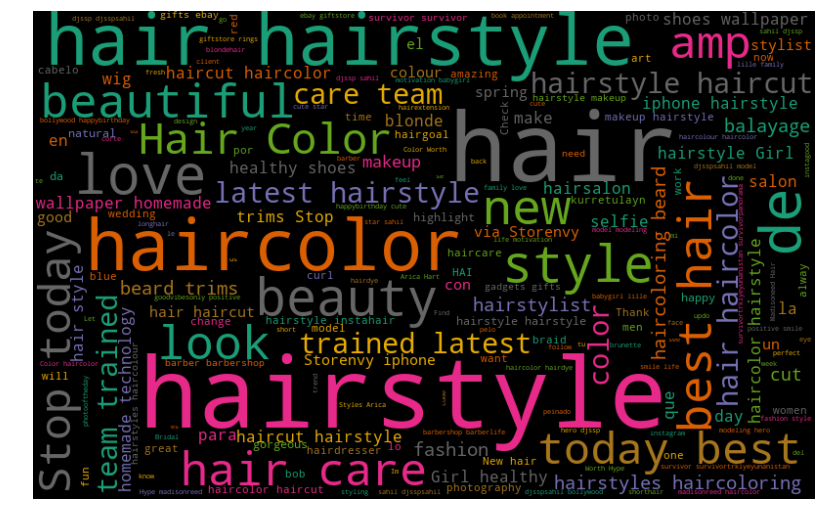

In [21]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

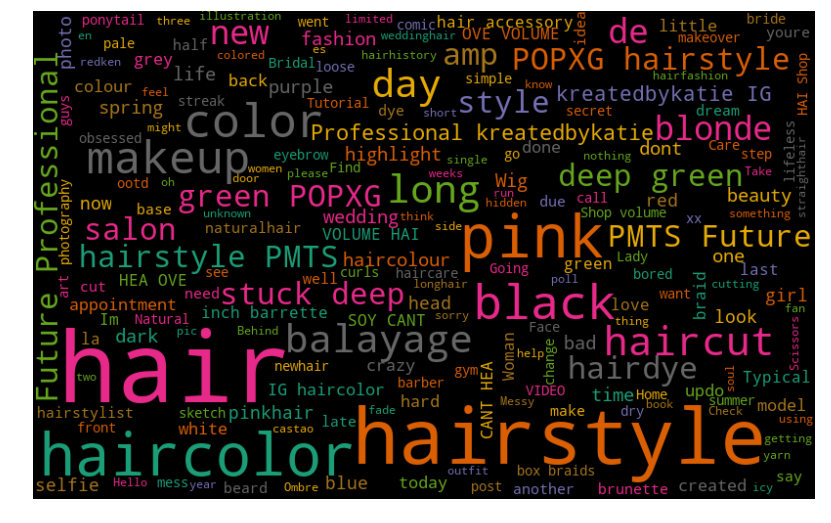

In [22]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)